# Pair correlation functions

In [1]:
import os
import tifffile
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops


In [2]:
# Functions

def compute_pair_corr(image_1, image_2):
    # Given a pair of segmentation masks,
    # return mixed species pair correlation between
    # cells in the two images.
    
    # get list of centroids and cell density for each image
    centroids_list1, density1 = image_to_centroids_and_density(image_1)
    centroids_list2, density2 = image_to_centroids_and_density(image_2)
    
    # total cell density is sum of each channel
    density = (density1 + density2)
    
    # max radius for searching pair correlation function is at most
    # half the smallest image dimension
    max_radius = np.min((np.min(image_1.shape), np.min(image_2.shape))) / 2
    
    # get mixed species pair correlation as list
    corr = get_pairwise_dist_two_color(centroids_list1, centroids_list2, 1, density, max_radius)    
    
    return corr


def image_to_centroids_and_density(image):
    # Given a segmentation mask of cells,
    # returns a list of cell centroids and the cell density
    
    # find cells using skimage label
    label_img = label(image)
    regions = regionprops(label_img)
    
    # get list of cell centroids
    centroids_list = []
    for region in regions:
        centroids_list.append(region.centroid)
    
    # calculate cell density in image
    density = len(centroids_list) / (np.shape(image)[0] * np.shape(image)[1])
    
    return centroids_list, density


def get_pairwise_dist_two_color(points1, points2, dr, density, max_radius):
    # Given a list of reference points and search points, a discretization size dr
    # cell density in images, and a max search radius
    # returns a normalized list of binned counts.
    
    # bin radial distances into size dr
    binned_counts = [0] * int(max_radius / dr)
    
    # iterate over all points and update binned_counts 
    for i in range(len(points1)):
        for j in range(len(points2)):
            binned_counts = normalized_count(dr, points1[i], points2[j], binned_counts, max_radius)
    
    # normalize by total count
    total_n = (len(points1) * len(points2)) / len(points1 + points2)
    binned_counts = np.array(binned_counts) / total_n
    
    # normalize by average density
    binned_counts = binned_counts / density

    return binned_counts


def normalized_count(dr, point1, point2, binned_counts, max_radius):
    # Given a discretization size df, a reference point point1, 
    # a relative point point2, a list of binned counts,
    # and the maximum search radius,
    # returns binned_counts list incremented by a area normalized count
    # if distance between points is less than the max_radius
    
    # calculate distance between points
    distance = np.sqrt((point1[0] - point2[0])**2 + 
                       (point1[1] - point2[1])**2)
    
    # only update count if distance < max_radius
    if distance < max_radius:
        # convert distance to index in binned_counts
        rad_index = int(distance/dr)
        
        # normalize count by radius and update binned_counts
        ring_area = corrected_area(distance, point1, 1920, 2048) * np.pi*(((rad_index+1)*dr)**2 - ((rad_index)*dr)**2)
        binned_counts[rad_index] += 1/ring_area
    
    return binned_counts


def corrected_area(radius, point, max_x, max_y):
    # Given a distance between points (radius), a reference point,
    # and the max image dimensions,
    # returns a corrected area that takes into account the search
    # radius being clipped by the image boundaries.
    
    # check each quadrant of the circle
    correction = [1,1,1,1] # quadrants starting TR - going CCW
    
    x_corrected_left = False
    x_corrected_right = False
    
    # check if the distance of the reference point to the left 
    # image border is smaller than the search radius
    # else, check if the distance of the reference point to the right 
    # image border is smaller than the search radius
    if point[0] < radius: 
        correction[1] = get_subangle(radius, point[0], 0)
        correction[2] = correction[1]
        x_corrected_left = True
    elif np.abs(max_x - point[0]) < radius:
        correction[0] = get_subangle(radius, point[0], max_x)
        correction[3] = correction[0]
        x_corrected_right = True

    # check again, this time for top and bottom borders
    if point[1] < radius:
        correction[2] = get_subangle(radius, point[1], 0)
        correction[3] = correction[2]
        if x_corrected_left:
            correction[2] = 0
        elif x_corrected_right:
            correction[3] = 0
    elif np.abs(max_y - point[1]) < radius:
        correction[0] = get_subangle(radius, point[1], max_y)
        correction[1] = correction[0]
        if x_corrected_left:
            correction[1] = 0
        elif x_corrected_right:
            correction[0] = 0    

    return np.sum(correction) / 4

    
def get_subangle(radius, point, edge):
    # Given a radial distance, a reference point, and image edge point
    # returns corrected sector area
    
    return (np.pi/2 - np.arccos(np.abs(edge-point)/radius)) / (np.pi/2)


In [3]:
# Compute mixed species pair correlation function between RFP and YFP cells

segs_dir = os.path.normpath(r'ConfocalData')

# Organize filenames by image stack
organized_data = {}
for im in os.listdir(segs_dir):
    experiment_name = '_'.join(im.split('_')[0:2])
    if experiment_name not in organized_data.keys():
        organized_data[experiment_name] = []
    organized_data[experiment_name].append(os.path.join(segs_dir, im))

# Compute mixed species pair correlation function for each experiment
pair_correlation_dict = {}
for experiment_name in organized_data.keys():
    print(f'Calculating pair corr for: {experiment_name}')
    image_1 = tifffile.imread(organized_data[experiment_name][0])[128:,:]
    image_2 = tifffile.imread(organized_data[experiment_name][1])[128:,:]
    pair_correlation_dict[experiment_name] = compute_pair_corr(image_1, image_2)


Calculating pair corr for: Ag2R_Ag2Y
Calculating pair corr for: Ag2R_Nb2Y


Text(0, 0.5, 'Pair correlation')

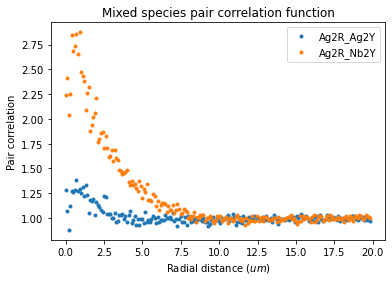

In [4]:
# Plot data

mpp = 0.0992 #microns per pixel

plt.figure()

for experiment_name in pair_correlation_dict.keys():
    plt.plot(mpp*np.linspace(0,200,200),
             pair_correlation_dict[experiment_name][:200],
             '.', label=experiment_name)

plt.title(f'Mixed species pair correlation function')
plt.legend(loc="upper right")
plt.xlabel('Radial distance ($um$)')
plt.ylabel('Pair correlation')
